#  **03: ETL - TWEETEVAL PREPROCESSING**
### José Eduardo Viveros Escamilla | A01710605
Objetivo:

* Adaptar un dataset más moderno de análisis de sentimiento (TweetEval/Twitter Tweets Sentiment) para usar Fine Tunning tecninca de transfer learning.
* Alinear el preprocesamiento al pipeline del V1 para permitir Fine-Tuning sin inconsistencias.

Acciones principales:

* Carga del dataset moderno y análisis de la distribución de clases.
* Limpieza equivalente al ETL del modelo base para mantener coherencia:
* URLs, menciones, hashtags, emojis, números, espaciado, normalización del texto.
* Uso del mismo Tokenizer del modelo base → evita romper la semántica aprendida.
* Conversión a secuencias y padding consistente.
* División del dataset en train/validation específico para fine-tuning.

Resultado producido:

* Secuencias alineadas al vocabulario del modelo base
* Listo para hacer Fine-Tuning con learning rate reducido.

In [154]:
import pandas as pd
import numpy as np
import re
import string
import emoji
import nltk
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

stop_words = set(stopwords.words('english'))
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\josed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [155]:
!pip install datasets

Descargamos nuesto dataset de hugginface

In [156]:
from datasets import load_dataset

# Cargar el subset de Sentiment
ds = load_dataset("cardiffnlp/tweet_eval", "sentiment")
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## TweetEval
El dataset TweetEval es un conjunto de datos ampliamente utilizado en investigación para analizar sentimiento en publicaciones reales de Twitter. Es considerado un benchmark moderno, ya que fue compilado como parte del trabajo de Barbieri et al., 2020 y se utiliza de manera estándar para evaluar modelos de NLP orientados a redes sociales.

Está compuesto por tweets reales, anotados con las clases:

* 0 → negativo
* 1 → neutral
* 2 → positivo

Es ideal para fine-tuning porque sirve como punto intermedio entre un dataset histórico como Sentiment140 (2009) y datasets más recientes o especializados (como los políticos que se usarán en v3).
Ha sido usado en trabajos importantes como Barbieri et al. (2020), BERTweet (Nguyen et al. 2020), XLM-T (Barbieri et al. 2021), y múltiples estudios en ACL. Su estabilidad y presentación estandarizada lo hacen perfecto para un pipeline de transferencia de aprendizaje progresivo.
- https://aclanthology.org/2020.tnlp-1.5/
- https://arxiv.org/abs/2107.07686
- https://aclanthology.org/2021.wassa-1.19/
- https://arxiv.org/abs/2005.10200

Eliminamos la feature 0 para que se compataible con las clases de nuestro primer modelo con el dataset Sentiment 140

In [157]:
# ================================================
# 1. TwitterEval
# ================================================

# Crear DataFrames iniciales
train_df = pd.DataFrame({
    "text": ds["train"]["text"],
    "label": ds["train"]["label"]
})

val_df = pd.DataFrame({
    "text": ds["validation"]["text"],
    "label": ds["validation"]["label"]
})

test_df = pd.DataFrame({
    "text": ds["test"]["text"],
    "label": ds["test"]["label"]
})

# Mostrar distribución original
print("Distribución ORIGINAL (0=neg,1=neutral,2=pos):")
print(train_df["label"].value_counts())

# 1) Eliminar neutrales (label=1)
train_df = train_df[train_df["label"] != 1]
val_df   = val_df[val_df["label"] != 1]
test_df  = test_df[test_df["label"] != 1]

# 2) Convertir 2 → 1 (pasar a binario)
train_df["label"] = train_df["label"].replace({2: 1})
val_df["label"]   = val_df["label"].replace({2: 1})
test_df["label"]  = test_df["label"].replace({2: 1})

print("\nDistribución FINAL (0=neg,1=pos):")
print(train_df["label"].value_counts())

Distribución ORIGINAL (0=neg,1=neutral,2=pos):
label
1    20673
2    17849
0     7093
Name: count, dtype: int64

Distribución FINAL (0=neg,1=pos):
label
1    17849
0     7093
Name: count, dtype: int64


Guardamos los datos en nuestro raw/data para poder tener trazabilidad de lo que usaremos para este ETL, a si mismo para poder consultarlo antes de las tranformaciones y limpieza que le haremos a todos los datos

In [158]:
train_df.to_csv("data/raw_data/TWEET_EVAL/tweeteval_sentiment_train.csv", index=False)
val_df.to_csv("data/raw_data/TWEET_EVAL/tweeteval_sentiment_val.csv", index=False)
test_df.to_csv("data/raw_data/TWEET_EVAL/tweeteval_sentiment_test.csv", index=False)

print("Archivos guardados correctamente en data/raw/")

Archivos guardados correctamente en data/raw/


Visualizamos los df con los que trabajaremos

In [159]:
train_df.head()

,text,label
0,"""QT @user In the original draft of the 7th boo...",1
4,@user Alciato: Bee will invest 150 million in ...,1
5,@user LIT MY MUM 'Kerry the louboutins I wonde...,1
6,"""\"""""""" SOUL TRAIN\"""""""" OCT 27 HALLOWEEN SPECIA...",1
7,So disappointed in wwe summerslam! I want to s...,0


In [160]:
val_df.head()

,text,label
1,"""National hot dog day, national tequila day, t...",1
2,When girls become bandwagon fans of the Packer...,0
6,#US 1st Lady Michelle Obama speaking at the 20...,1
7,Omg this show is so predictable even for the 3...,0
8,"""What a round by Paul Dunne, good luck tomorro...",1


In [161]:
test_df.head()

,text,label
3,I think I may be finally in with the in crowd ...,1
4,"@user Wow,first Hugo Chavez and now Fidel Cast...",0
7,Twitter's #ThankYouObama Shows Heartfelt Grati...,1
9,@user @user @user @user @user @user take away ...,0
12,#onedirection #harrystyles cute little dance 😉,1


In [162]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6347 entries, 3 to 12283
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6347 non-null   object
 1   label   6347 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 148.8+ KB


In [163]:
print("Train:")
print(train_df["label"].value_counts())

print("\nVal:")
print(val_df["label"].value_counts())

print("\nTest:")
print(test_df["label"].value_counts())


Train:
label
1    17849
0     7093
Name: count, dtype: int64

Val:
label
1    819
0    312
Name: count, dtype: int64

Test:
label
0    3972
1    2375
Name: count, dtype: int64


Usamos la misma funcion que utilizamos en nuestro primer ETL para la **Limpieza de datos** de los 3 sets de datos

In [164]:
def clean_text(text):
    # 1. A minúsculas
    text = str(text)
    text = text.lower()

    # 2. Quitar URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 3. Quitar menciones y hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # 4. Quitar números y puntuación
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 5. Quitar emojis
    text = emoji.replace_emoji(text, replace='')
    
    # 6. Quitar palabras vacías (stopwords)
    tokens = [word for word in text.split() if word not in stop_words]
    text = ' '.join(tokens)
    
    return text

train_df["text_clean"] = train_df["text"].apply(clean_text)
val_df["text_clean"]   = val_df["text"].apply(clean_text)
test_df["text_clean"]  = test_df["text"].apply(clean_text)

# Dropeamos la columna text original
train_df = train_df[["text_clean", "label"]]
val_df   = val_df[["text_clean", "label"]]
test_df  = test_df[["text_clean", "label"]]

train_df.head()


,text_clean,label
0,qt original draft th book remus lupin survived...,1
4,alciato bee invest million january another sum...,1
5,lit mum kerry louboutins wonder many willam ow...,1
6,soul train oct halloween special ft tdot fines...,1
7,disappointed wwe summerslam want see john cena...,0


In [165]:
val_df.head()

,text_clean,label
1,national hot dog day national tequila day nati...,1
2,girls become bandwagon fans packers harry yall...,0
6,st lady michelle obama speaking beating odds s...,1
7,omg show predictable even rd ep rui enus ex bo...,0
8,round paul dunne good luck tomorrow hope win open,1


In [166]:
test_df.head()

,text_clean,label
3,think may finally crowd,1
4,wowfirst hugo chavez fidel castro danny glover...,0
7,twitters shows heartfelt gratitude potus,1
9,take away illegals dead people trump wins popu...,0
12,cute little dance,1


Aqui es donde unimos los tres sets para poder unirlo con el siguiente dataset y poder splitear de forma proporcional

In [167]:
tweet_all = pd.concat([train_df, val_df, test_df], ignore_index=True)
tweet_all.head()


,text_clean,label
0,qt original draft th book remus lupin survived...,1
1,alciato bee invest million january another sum...,1
2,lit mum kerry louboutins wonder many willam ow...,1
3,soul train oct halloween special ft tdot fines...,1
4,disappointed wwe summerslam want see john cena...,0


In [168]:
tweet_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32420 entries, 0 to 32419
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text_clean  32420 non-null  object
 1   label       32420 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 506.7+ KB


## Twitter Tweets Sentiment Dataset


In [169]:
# ================================================
# 2. Twitter Tweets Sentiment Dataset (Kaggle)
# ================================================

kaggle_df = pd.read_csv("C:/Users/josed/Documents/IA/BENJI/data/raw_data/Tweets.csv", encoding="utf-8")

print("Kaggle dataset shape:", kaggle_df.shape)
kaggle_df.head()

Kaggle dataset shape: (27481, 4)


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [170]:
kaggle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [171]:
kaggle_df["text_clean"] = kaggle_df["text"].apply(clean_text)
kaggle_df = kaggle_df[["text_clean", "sentiment"]]
kaggle_df.head()

,text_clean,sentiment
0,id responded going,neutral
1,sooo sad miss san diego,negative
2,boss bullying,negative
3,interview leave alone,negative
4,sons couldnt put releases already bought,negative


In [172]:
kaggle_df.columns
kaggle_df.head()
kaggle_df.dtypes
print(kaggle_df.nunique())
print(kaggle_df.iloc[0])

text_clean    26826
sentiment         3
dtype: int64
text_clean    id responded going
sentiment                neutral
Name: 0, dtype: object


In [173]:
kagle_new_df = kaggle_df.copy()
kaggle_df["sentiment"].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

Convertimos el dataset triclase a binario volviendo neutral como negativo para evitar confusiones

In [174]:
def map_to_binary(label):
    label = str(label).lower()
    if label == "positive":
        return 1
    else:
        return 0  # neutral y negative se vuelven 0
        

kaggle_df["sentiment"] = kaggle_df["sentiment"].apply(map_to_binary)
kaggle_df.head()
kaggle_df["sentiment"].unique()


array([0, 1], dtype=int64)

Renombramos sentiment como label para que coincida con el dataset de arriba

In [175]:
kaggle_df = kaggle_df.rename(columns={"sentiment": "label"})
print(kaggle_df.columns)
kaggle_df.head()

Index(['text_clean', 'label'], dtype='object')


,text_clean,label
0,id responded going,0
1,sooo sad miss san diego,0
2,boss bullying,0
3,interview leave alone,0
4,sons couldnt put releases already bought,0


In [176]:
kaggle_df["label"].value_counts()

label
0    18899
1     8582
Name: count, dtype: int64

## Merge Datases: TwitterEval - Twitter Sentiment Dataset

Ahora con el dataset ya listo lo spliteamos en train, test y validation como TweetEval viene orginalmete 

In [177]:
tweet_all = tweet_all[["text_clean", "label"]]
kaggle_df = kaggle_df[["text_clean", "label"]]

In [178]:
all_data = pd.concat([tweet_all, kaggle_df], ignore_index=True)


In [179]:
all_data = all_data.drop_duplicates(subset=["text_clean"])

In [180]:
all_data = all_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [181]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59098 entries, 0 to 59097
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text_clean  59098 non-null  object
 1   label       59098 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 923.5+ KB


In [182]:
from sklearn.model_selection import train_test_split

train_split = 0.6
val_split   = 0.2
test_split  = 0.2

df_train, df_temp = train_test_split(
    all_data, test_size=val_split + test_split, random_state=42
)

df_val, df_test = train_test_split(
    df_temp, test_size=test_split / (val_split + test_split), random_state=42
)
print("Train shape:", df_train.shape)
print("Val shape:", df_val.shape)
print("Test shape:", df_test.shape)

Train shape: (35458, 2)
Val shape: (11820, 2)
Test shape: (11820, 2)


Hacemos graficas de la distribucion de los datos y ver si estan balalnceados para poder realizar la mejora al modelo

C:\Users\josed\AppData\Local\Temp\ipykernel_6224\613857354.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], data=all_data, x="label", palette="Set2")


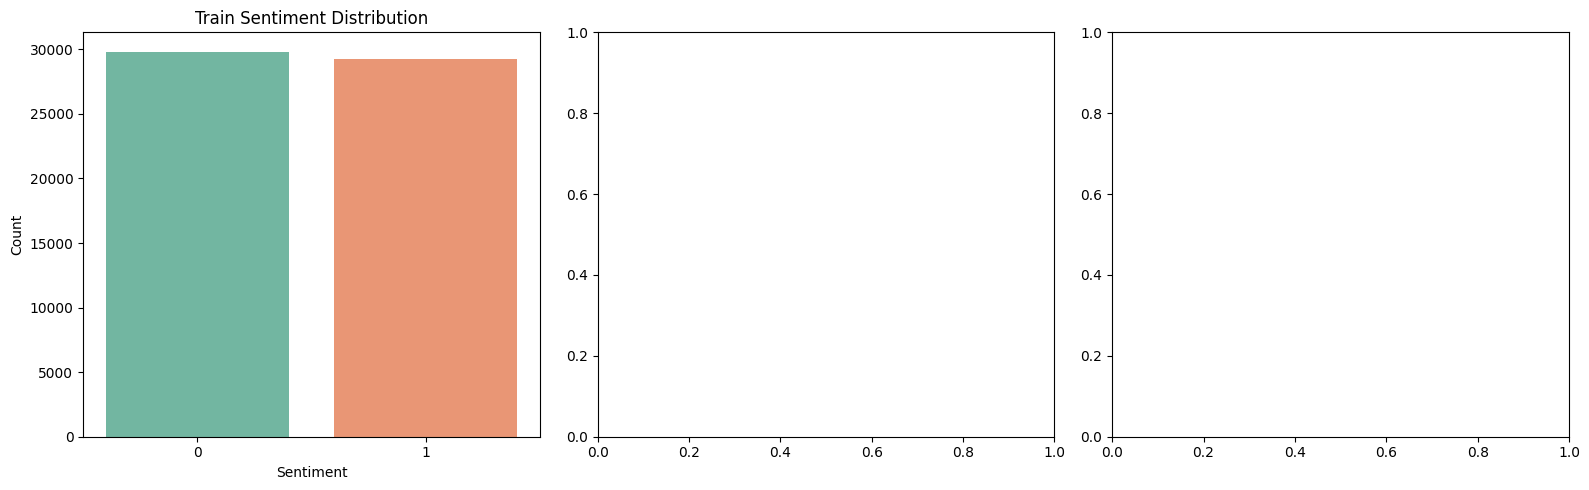

In [183]:

fig, axes = plt.subplots(1, 3, figsize=(16,5))

sns.countplot(ax=axes[0], data=all_data, x="label", palette="Set2")
axes[0].set_title("Train Sentiment Distribution")
axes[0].set_xlabel("Sentiment")
axes[0].set_ylabel("Count")
plt.tight_layout()
plt.show()


Cargamos el tokenixer.pkl de nuestro primer modelo

In [184]:
import pickle

TOKENIZER_PATH = "data/processed_data/v1_base/tokenizer.pkl"
with open(TOKENIZER_PATH, "rb") as f:
    tokenizer = pickle.load(f)

print("Tokenizer cargado correctamente.")

Tokenizer cargado correctamente.


In [185]:
MAX_LEN = 50
print("MAX_LEN =", MAX_LEN)

MAX_LEN = 50


In [186]:
X_train_seq = tokenizer.texts_to_sequences(df_train["text_clean"])
X_val_seq   = tokenizer.texts_to_sequences(df_val["text_clean"])
X_test_seq  = tokenizer.texts_to_sequences(df_test["text_clean"])

len(X_train_seq), len(X_val_seq), len(X_test_seq)

(35458, 11820, 11820)

In [187]:
X_train = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post")
X_val   = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding="post")
X_test  = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post")

X_train.shape, X_val.shape, X_test.shape

((35458, 50), (11820, 50), (11820, 50))

In [188]:
y_train = df_train["label"].values
y_val   = df_val["label"].values
y_test  = df_test["label"].values

y_train[:10]

array([1, 1, 0, 0, 1, 0, 0, 1, 0, 0], dtype=int64)

In [189]:
OUTPUT_DIR = "data/processed_data/v2_modern/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Carpeta creada:", OUTPUT_DIR)


Carpeta creada: data/processed_data/v2_modern/


In [190]:
np.save(OUTPUT_DIR + "X_train.npy", X_train)
np.save(OUTPUT_DIR + "X_val.npy", X_val)
np.save(OUTPUT_DIR + "X_test.npy", X_test)

np.save(OUTPUT_DIR + "y_train.npy", y_train)
np.save(OUTPUT_DIR + "y_val.npy", y_val)
np.save(OUTPUT_DIR + "y_test.npy", y_test)

print("Archivos .npy guardados exitosamente.")

Archivos .npy guardados exitosamente.
